In [55]:
#ngboost and modelling libraries
from ngboost import NGBClassifier
from ngboost.distns import Bernoulli
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import roc_auc_score, roc_curve, classification_report
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from imblearn.over_sampling import SMOTE
from collections import Counter

#data manipulation libraries
import pandas as pd
import numpy as np

from plotly.offline import init_notebook_mode
init_notebook_mode(connected=True)

#ignore warnings
import warnings
warnings.filterwarnings('ignore')

#import functions and constants
from utils import (register_imputation, preprocess_df, 
                    scaling_values_df, clean_outliers, get_sample_weights, 
                  process_unit_cost, cost_score, generate_y_pred_with_custom_threshold, )
from plot_utils import (correlation_heatmap, visualize_permutation_feature_importances, 
                        plot_target_balance, plot_trace_line, plot_scatter_matrix, 
                        plot_feature_importances, visualize_roc_curve, color_negative_red, )

from constants import cols, cols_with_missing_indicators

In [56]:
df = pd.read_csv("./data/cs-training.csv", usecols =cols).fillna(0)

In [57]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
pca = PCA(n_components=2)
x = df.loc[:, cols[1:]].values
# Separating out the target
y = df.loc[:,[cols[0]]].values
# Standardizing the features
x = StandardScaler().fit_transform(x)
principalComponents = pca.fit_transform(x)
principalDf = pd.DataFrame(data = principalComponents, columns = ['principal component 1', 'principal component 2'])

In [58]:
principalDf

,principal component 1,principal component 2
0,-0.142754,3.716037
1,0.039126,-1.261171
2,0.358680,-1.695240
3,0.070621,-1.408882
4,-0.030521,0.896041
...,...,...
149995,-0.132267,-0.664609
149996,-0.036281,-0.377586
149997,-0.297301,1.159503
149998,0.082102,-1.477502


In [59]:
df_merge = pd.merge(principalDf.reset_index(), pre_df)

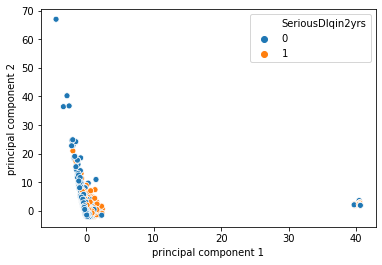

In [62]:
import seaborn as sns
ax = sns.scatterplot(x="principal component 1", y="principal component 2",
                     hue="SeriousDlqin2yrs", data=df_merge)

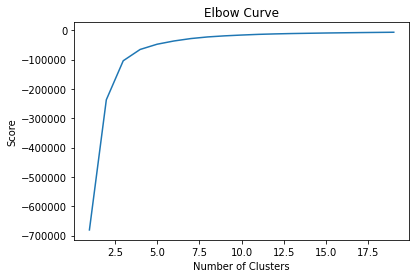

In [28]:
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

Nc = range(1, 20)
kmeans = [KMeans(n_clusters=i) for i in Nc]
kmeans
score = [kmeans[i].fit(principalDf).score(principalDf) for i in range(len(kmeans))]
score
plt.plot(Nc,score)
plt.xlabel('Number of Clusters')
plt.ylabel('Score')
plt.title('Elbow Curve')
plt.show()

In [20]:
score

[-1500000.0,
 -1055709.6050582852,
 -916900.0254477672,
 -819730.1476950842,
 -731019.6663265944,
 -643411.7134211509,
 -563842.9726104046,
 -484584.09756382945,
 -454693.5642853744,
 -421877.29686110216,
 -395597.10466800194,
 -380933.58413780504,
 -348414.9377443143,
 -331309.7664000094,
 -321516.4893951901,
 -308325.53656586807,
 -298262.93020901474,
 -284468.85714663804,
 -273969.5167110938]

In [ ]:
 -1055709.6050582852, 2
    

In [29]:
kmeans = KMeans(n_clusters=2).fit(x)
centroids = kmeans.cluster_centers_
print(centroids)

[[ 3.63148460e-05  2.19523151e-03 -4.17955963e-02  3.06152650e-04
   5.38370328e-04  2.94844294e-03 -4.20977643e-02  1.61920464e-03
  -4.22519267e-02  6.65827713e-04]
 [-2.02135993e-02 -1.22191156e+00  2.32642990e+01 -1.70410938e-01
  -2.99668132e-01 -1.64116472e+00  2.34324920e+01 -9.01283010e-01
   2.35183020e+01 -3.70613566e-01]]


In [37]:
kmeans.predict(x)

array([0, 0, 0, ..., 0, 0, 0], dtype=int32)

In [38]:
principalDf["cluster"] = kmeans.predict(x)

In [41]:
principalDf.groupby(["cluster"]).count()

,principal component 1,principal component 2
cluster,,
0,149731,149731
1,269,269


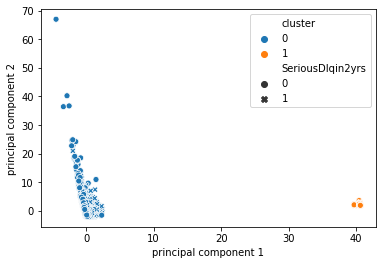

In [54]:
import seaborn as sns
ax = sns.scatterplot(x="principal component 1", y="principal component 2",
                     hue="cluster", style="SeriousDlqin2yrs", data=df_merged)

In [71]:
df_blue_circle = df_merged[(df_merged["cluster"]==0) &  (df_merged["SeriousDlqin2yrs"]==0)] #blue and circle
df_blue_x = df_merged[(df_merged["cluster"]==0) &  (df_merged["SeriousDlqin2yrs"]==1)] #blue and x
df_orange_circle = df_merged[(df_merged["cluster"]==1) &  (df_merged["SeriousDlqin2yrs"]==0)] #red and circle
df_orange_x = df_merged[(df_merged["cluster"]==1) &  (df_merged["SeriousDlqin2yrs"]==1)] #red and x


In [72]:
df_merged.columns

Index(['index', 'principal component 1', 'principal component 2', 'cluster',
       'SeriousDlqin2yrs'],
      dtype='object')

In [ ]:
import plotly.graph_objs as go
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot

# Add traces
data1 = go.Scatter(x=df_blue_circle['principal component 1'], y=df_blue_circle['principal component 2'],
                    mode='markers',  marker_color = "green",opacity=0.8,
                    name='Responsible (target = 0) - cluster 0')
# Add traces
data2 = go.Scatter(x=df_blue_x['principal component 1'], y=df_blue_x['principal component 2'],
                    mode='markers',marker_symbol="x",  marker_color = "yellow",opacity=0.8,
                    name='Responsible (target = 0) -  cluster 1')

# Add traces
data3 = go.Scatter(x=df_orange_circle['principal component 1'], y=df_orange_circle['principal component 2'],
                    mode='markers',  marker_color = "red",opacity=0.8,
                    name='Delinquent (target = 1) - cluster 0')

# Add traces
data4 = go.Scatter(x=df_orange_x['principal component 1'], y=df_orange_x['principal component 2'],
                    mode='markers',marker_symbol="x",  marker_color = "blue",opacity=0.8,
                    name='Delinquent (target = 1) - cluster 1')

layout = dict(title= f"PCA + K MEANS CLUSTERING DATA VIZ", 
            xaxis= {"title": "Principal Component 1"}, 
            yaxis= {"title": "Principal Component 2"})


fig = go.Figure(data=[data1, data2, data3, data4], layout=layout)
iplot(fig)


In [64]:
import plotly.express as px
px.scatter?

In [48]:
principalDf = principalDf.copy().reset_index()

In [50]:
pre_df = df[["SeriousDlqin2yrs"]].reset_index()
pre_df

,index,SeriousDlqin2yrs
0,0,1
1,1,0
2,2,0
3,3,0
4,4,0
...,...,...
149995,149995,0
149996,149996,0
149997,149997,0
149998,149998,0


In [52]:
df_merged = pd.merge(principalDf, pre_df, on = "index")

In [ ]:
kmeans = KMeans(n_clusters=8).fit(x)
centroids = kmeans.cluster_centers_
print(centroids)

In [ ]:
import seaborn as sns; sns.set()
import matplotlib.pyplot as plt
ax = sns.scatterplot(x="total_bill", y="tip", data=tips)

In [10]:
principalDf

,principal component 1,principal component 2
0,-0.142754,3.716037
1,0.039126,-1.261171
2,0.358680,-1.695240
3,0.070621,-1.408882
4,-0.030521,0.896041
...,...,...
149995,-0.132267,-0.664609
149996,-0.036281,-0.377586
149997,-0.297301,1.159503
149998,0.082102,-1.477502


In [ ]:
df = clean_outliers(df.copy(), True)

In [ ]:
X = df.drop(columns=['SeriousDlqin2yrs']).values
y = df.SeriousDlqin2yrs.values

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
from sklearn.metrics import roc_auc_score
df_collector_estimators = pd.DataFrame(columns=  ["estimators", "cost", "train_auc", "test_auc"])
k = 0
for estimator in [50,60,65, 75, 80,100, 120, 150]:
    print("estimators: {estimator}")
    ngb_clf = NGBClassifier(Dist=Bernoulli, verbose=True, n_estimators = estimator,  verbose_eval = 0)
    ngb_clf.fit(X_train_resampled, y_train_resampled, sample_weight= get_sample_weights(y_train, y_train_resampled))
    df_aux = pd.DataFrame(X_test, columns=cols[1:])
    df_aux['predicted'] = generate_y_pred_with_custom_threshold(ngb_clf, X_test, 0.75)
    df_aux['real'] = list(y_test)
    df_aux['LoanPrincipal'] = df_aux.MonthlyIncome * 2
    df_collector_estimators.ix[str(k),'estimators'] = estimator
    df_collector_estimators.ix[str(k),'cost'] = cost_score(df_aux.LoanPrincipal, df_aux.predicted, df_aux.real)
    # predict probabilities
    train_probs = ngb_clf.predict_proba(X_train)
    test_probs = ngb_clf.predict_proba(X_test)
    # keep probabilities for the positive outcome only
    train_probs = train_probs[:, 1]
    test_probs = test_probs[:, 1]
    # calculate scores
    train_auc = roc_auc_score(y_train, train_probs)
    test_auc = roc_auc_score(y_test, test_probs)
    df_collector_estimators.ix[str(k),'train_auc'] = train_auc
    df_collector_estimators.ix[str(k),'test_auc'] = test_auc
    k+=1
    del ngb_clf
    

df_collector_lr = pd.DataFrame(columns=  ["lr", "cost", "train_auc", "test_auc"])
k = 0
for lr in [0.1, 0.01, 0.001, 0.0001]:
    print("learning_rate: {lr}")
    ngb_clf = NGBClassifier(Dist=Bernoulli, verbose=True, learning_rate = lr,  verbose_eval = 0)
    ngb_clf.fit(X_train_resampled, y_train_resampled, sample_weight= get_sample_weights(y_train, y_train_resampled))
    df_aux = pd.DataFrame(X_test, columns=cols[1:])
    df_aux['predicted'] = generate_y_pred_with_custom_threshold(ngb_clf, X_test, 0.75)
    df_aux['real'] = list(y_test)
    df_aux['LoanPrincipal'] = df_aux.MonthlyIncome * 2
    df_collector_lr.ix[str(k),'lr'] = lr
    df_collector_lr.ix[str(k),'cost'] = cost_score(df_aux.LoanPrincipal, df_aux.predicted, df_aux.real)
    # predict probabilities
    train_probs = ngb_clf.predict_proba(X_train)
    test_probs = ngb_clf.predict_proba(X_test)
    # keep probabilities for the positive outcome only
    train_probs = train_probs[:, 1]
    test_probs = test_probs[:, 1]
    # calculate scores
    train_auc = roc_auc_score(y_train, train_probs)
    test_auc = roc_auc_score(y_test, test_probs)
    df_collector_lr.ix[str(k),'train_auc'] = train_auc
    df_collector_lr.ix[str(k),'test_auc'] = test_auc
    k+=1
    del ngb_clf
    
    
df_collector_base = pd.DataFrame(columns=  ["base", "cost", "train_auc", "test_auc"])
k = 0
for base in [base1,base2,base3]:
    print("Base: {base}")
    ngb_clf = NGBClassifier(Dist=Bernoulli, verbose=True, Base=base,  verbose_eval = 0)
    ngb_clf.fit(X_train_resampled, y_train_resampled, sample_weight= get_sample_weights(y_train, y_train_resampled))
    df_aux = pd.DataFrame(X_test, columns=cols[1:])
    df_aux['predicted'] = generate_y_pred_with_custom_threshold(ngb_clf, X_test, 0.75)
    df_aux['real'] = list(y_test)
    df_aux['LoanPrincipal'] = df_aux.MonthlyIncome * 2
    df_collector_base.ix[str(k),'base'] = base
    df_collector_base.ix[str(k),'cost'] = cost_score(df_aux.LoanPrincipal, df_aux.predicted, df_aux.real)
    # predict probabilities
    train_probs = ngb_clf.predict_proba(X_train)
    test_probs = ngb_clf.predict_proba(X_test)
    # keep probabilities for the positive outcome only
    train_probs = train_probs[:, 1]
    test_probs = test_probs[:, 1]
    # calculate scores
    train_auc = roc_auc_score(y_train, train_probs)
    test_auc = roc_auc_score(y_test, test_probs)
    df_collector_base.ix[str(k),'train_auc'] = train_auc
    df_collector_base.ix[str(k),'test_auc'] = test_auc
    k+=1
    del ngb_clf

In [ ]:
df_collector_lr

In [ ]:
trace0 = go.Scatter(
        x=df_collector_estimators.estimators,
        y=df_collector_estimators.cost,
        name="cost",
        line=dict(color="rgb(167, 103, 4)", width=4),
    )
data = [trace0]

# Edit the layout
layout = dict(
        title=f"Evolution of performance metrics according to # of estimators",
        xaxis=dict(title="# Estimators"),
        yaxis=dict(title=f"Cost"),
)

fig = dict(data=data, layout=layout)
iplot(fig)

In [ ]:
trace1 = go.Scatter(
        x=df_collector_estimators.estimators,
        y=df_collector_estimators.train_auc,
        name="train_auc",
        line=dict(color="blue", width=4),
    )

trace2 = go.Scatter(
        x=df_collector_estimators.estimators,
        y=df_collector_estimators.test_auc,
        name="test_auc",
        line=dict(color="gray", width=4),
    )
data = [trace1, trace2]

# Edit the layout
layout = dict(
        title=f"Evolution of performance metrics according to # of estimators",
        xaxis=dict(title="# Estimators"),
        yaxis=dict(title=f"AUC (train/test)"),
)

fig = dict(data=data, layout=layout)
iplot(fig)

In [ ]:
trace0 = go.Scatter(
        x=df_collector_lr.lr,
        y=df_collector_lr.cost,
        name="cost",
        line=dict(color="rgb(167, 103, 4)", width=4),
    )
data = [trace0]

# Edit the layout
layout = dict(
        title=f"Evolution of performance metrics according to learning_rate",
        xaxis=dict(title="Learning_rate"),
        yaxis=dict(title=f"Cost"),
)

fig = dict(data=data, layout=layout)
iplot(fig)

In [ ]:
trace1 = go.Scatter(
        x=df_collector_lr.lr,
        y=df_collector_lr.train_auc,
        name="train_auc",
        line=dict(color="blue", width=4),
    )

trace2 = go.Scatter(
        x=df_collector_lr.lr,
        y=df_collector_lr.test_auc,
        name="test_auc",
        line=dict(color="gray", width=4),
    )
data = [trace1, trace2]

# Edit the layout
layout = dict(
        title=f"Evolution of performance metrics according to learning_rate",
        xaxis=dict(title="learning_rate"),
        yaxis=dict(title=f"AUC (train/test)"),
)

fig = dict(data=data, layout=layout)
iplot(fig)

In [ ]:
trace0 = go.Scatter(
        x=[df_collector_base['base'].iloc[i].max_depth for i in range(len(df_collector_base['base']))],
        y=df_collector_base.cost,
        name="cost",
        line=dict(color="rgb(167, 103, 4)", width=4),
    )
data = [trace0]

# Edit the layout
layout = dict(
        title=f"Evolution of performance metrics according to the max_depth of Base Learner",
        xaxis=dict(title="max_depth of Base Learner"),
        yaxis=dict(title=f"Cost"),
)

fig = dict(data=data, layout=layout)
iplot(fig)

In [ ]:
trace1 = go.Scatter(
        x=[df_collector_base['base'].iloc[i].max_depth for i in range(len(df_collector_base['base']))],
        y=df_collector_base.train_auc,
        name="train_auc",
        line=dict(color="blue", width=4),
    )

trace2 = go.Scatter(
        x=[df_collector_base['base'].iloc[i].max_depth for i in range(len(df_collector_base['base']))],
        y=df_collector_base.test_auc,
        name="test_auc",
        line=dict(color="gray", width=4),
    )
data = [trace1, trace2]

# Edit the layout
layout = dict(
        title=f"Evolution of performance metrics according to the max_depth of Base Learner",
        xaxis=dict(title="max_depth of Base Learner"),
        yaxis=dict(title=f"AUC (train/test)"),
)

fig = dict(data=data, layout=layout)
iplot(fig)